## 1. Setup and Data Acquisition
First, we'll import the necessary libraries, load the stock data, and visualize the closing prices.

In [4]:
# Import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [5]:
# Download Apple Inc. (AAPL) stock data
stock_data = yf.download('AAPL', start='2022-01-01', end='2024-01-01')

[*********************100%***********************]  1 of 1 completed


In [6]:
# Reset the index to use the 'Date' column properly
stock_data.reset_index(inplace=True)

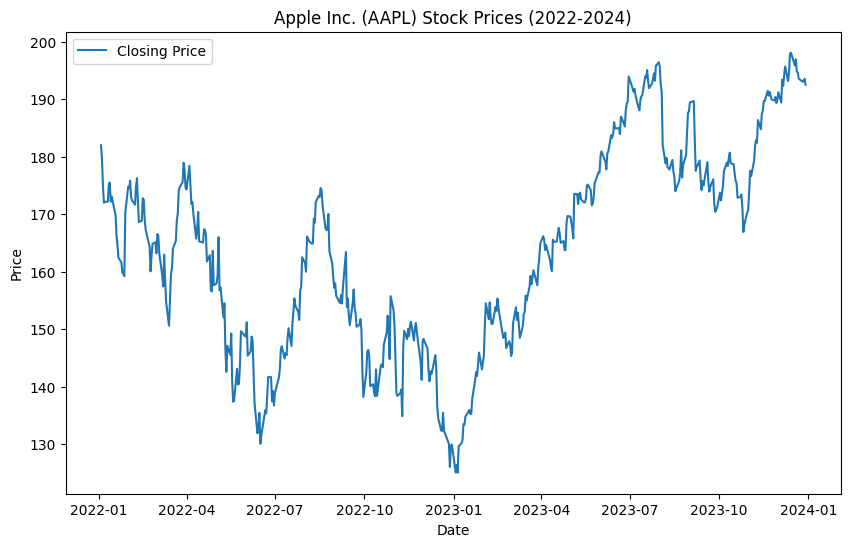

In [7]:
# Plot the closing prices
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Date'], stock_data['Close'], label='Closing Price')
plt.title('Apple Inc. (AAPL) Stock Prices (2022-2024)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## 2. Data Preprocessing
1. Normalize the data to a range between 0 and 1.
2. Create sequences for the LSTM (typically using previous 60 days to predict the next day).
3. Split the data into training and testing sets (80% train, 20% test).

In [8]:
# Extract the 'Close' column for LSTM model
close_prices = stock_data['Close'].values

In [9]:
# Normalize the closing prices to the range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices.reshape(-1, 1))

In [10]:
# Create sequences of 60 timesteps to predict the next timestep
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])  # Previous 'sequence_length' prices
        y.append(data[i, 0])  # The next price
    return np.array(X), np.array(y)

In [11]:
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [12]:
# Generate X_train, y_train, X_test, y_test
X_train, y_train = create_sequences(train_data, sequence_length=60)
X_test, y_test = create_sequences(test_data, sequence_length=60)

In [13]:
# Reshape input data to 3D for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [14]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (340, 60, 1), y_train shape: (340,)
X_test shape: (41, 60, 1), y_test shape: (41,)


## 3. LSTM Model Implementation
1. Define the LSTM model with layers.
2. Compile the model using an optimizer and loss function.
3. Train the model on training data.

In [15]:
# Define the LSTM model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

C:\Users\RISHABH RATHORE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# Add output layer
model.add(Dense(units=1))  # Predict the next price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - loss: 0.1288 - val_loss: 0.0568
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0289 - val_loss: 0.0284
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0225 - val_loss: 0.0627
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0186 - val_loss: 0.0114
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0145 - val_loss: 0.0059
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0137 - val_loss: 0.0139
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0112 - val_loss: 0.0133
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0107 - val_loss: 0.0063
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0107 - val_loss: 0.0151
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0092 - val_loss: 0.0072
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0094 - val_loss: 0.0078
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.

## 4. Model Prediction and Visualization
1. Make predictions on the test set.
2. Inverse transform the scaled data to get the original price values.
3. Visualize the predictions alongside the actual stock prices.

In [18]:
# Predict on the test set
predicted_prices = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step


In [19]:
# Inverse scale the predictions and the y_test values
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

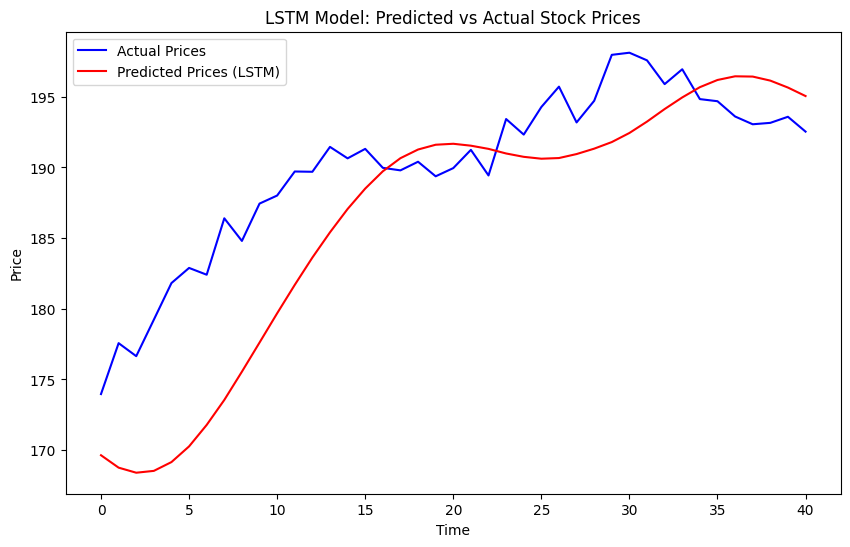

In [20]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Prices', color='blue')
plt.plot(predicted_prices, label='Predicted Prices (LSTM)', color='red')
plt.title('LSTM Model: Predicted vs Actual Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## 5. Model Evaluation
1. Calculate evaluation metrics (MAE, MSE, and RMSE) to assess performance.
2. Print the results for comparison with the core models (Linear Regression and Exponential Smoothing).

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate performance metrics for LSTM
mae_lstm = mean_absolute_error(y_test_rescaled, predicted_prices)
mse_lstm = mean_squared_error(y_test_rescaled, predicted_prices)
rmse_lstm = np.sqrt(mse_lstm)

In [22]:
# Print the performance metrics
print('Performance Metrics for LSTM:')
print(f'MAE: {mae_lstm:.2f}, MSE: {mse_lstm:.2f}, RMSE: {rmse_lstm:.2f}')

Performance Metrics for LSTM:
MAE: 4.81, MSE: 36.60, RMSE: 6.05
